In [1]:
import importlib
import matplotlib.pyplot as mp
import numpy as np

%matplotlib inline

from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz




In [2]:
import pandas as pd

In [3]:
def get_data(filename, comma):
    
    if comma:
        df = pd.read_csv(filename)
    else:
        df = pd.read_csv(filename, sep=';')
    return df

In [4]:
bagsdf = get_data('testdata.csv', True)


In [5]:
bagsdf.head()

,Unnamed: 0,MinLoggedUTC,MaxExternalBookingID,PaxType,ChannelID,RoleName,TripOriginLocationCode,TripDestinationLocationCode,NumberOfPassengers,FareClass,...,TreatmentRanked,TreatmentIDBook,QuantityBooked,FinalStage,ProductID,ProductName,Amount,OriginalPrice,Role_Type,Price_Type
0,0,7/1/2019 12:00:25 AM,95612682,ADT,2,WWWM,RDU,DTW,2,Z,...,2,0,0,0,78,BAG1,33.0,30.0,INITIAL,CONTROL
1,1,7/1/2019 12:00:25 AM,95612682,ADT,2,WWWM,RDU,DTW,2,Z,...,2,0,0,0,84,COB1,36.0,25.0,INITIAL,CONTROL
2,2,7/1/2019 12:00:28 AM,95612977,ADT,2,TCMM,DEN,HRL,2,W,...,1,0,0,0,78,BAG1,37.0,30.0,INITIAL,DISCOUNT
3,3,7/1/2019 12:00:28 AM,95612977,ADT,2,TCMM,DEN,HRL,2,W,...,1,0,0,0,84,COB1,34.0,25.0,INITIAL,DISCOUNT
4,4,7/1/2019 12:00:28 AM,95612977,ADT,2,TCMM,DEN,HRL,2,W,...,2,0,0,0,78,BAG1,29.0,30.0,INITIAL,DISCOUNT


In [6]:
bagsdf.drop("Unnamed: 0", axis=1, inplace=True)

In [7]:
bagsdf.columns

Index(['MinLoggedUTC', 'MaxExternalBookingID', 'PaxType', 'ChannelID',
       'RoleName', 'TripOriginLocationCode', 'TripDestinationLocationCode',
       'NumberOfPassengers', 'FareClass', 'TripType', 'TreatmentRank',
       'SegmentOriginLocationCode', 'SegmentDestinationLocationCode',
       'TripReturnTravelDate', 'TripFirstTravelDate', 'SegmentFirstTravelDate',
       'TotalFare', 'JourneySalesDate', 'AgeOfPassengersArray',
       'FirstPaxProgramLevel', 'TreatmentProductSequence', 'TreatmentRanked',
       'TreatmentIDBook', 'QuantityBooked', 'FinalStage', 'ProductID',
       'ProductName', 'Amount', 'OriginalPrice', 'Role_Type', 'Price_Type'],
      dtype='object')

# Feature Engineering

### Fortnight Stay 
- Feature for if duration of trip is greater than 14 days

In [8]:
def fortnightDuration(firstTravelDate, returnTravelDate):
    
    firstTravel= datetime.datetime.strptime(firstTravelDate.split(' ')[0], '%m/%d/%Y')
    returnTravel= 0
    if isinstance(returnTravelDate,str):
        returnTravel= datetime.datetime.strptime(returnTravelDate.split(' ')[0], '%m/%d/%Y') 
    if(returnTravel!=0):
        elapsed_time= returnTravel-firstTravel
        duration_val= (1 if((abs(elapsed_time.days))>= 14 ) else 0)
                       
    else:
        duration_val=0
        
    return duration_val

In [9]:
bagsdf['FortnightStay']=pd.Series()

In [10]:
bagsdf['FortnightStay']= list(map(fortnightDuration,bagsdf['TripFirstTravelDate'], bagsdf['TripReturnTravelDate']))

In [11]:
bagsdf['FortnightStay'].value_counts()

0    9710
1     290
Name: FortnightStay, dtype: int64

### Round Trip 
- Whether the booking is round trip or one way 
- If TripOriginLocationCode == SegmentDestinationLocationCode

In [12]:
bagsdf[['TripOriginLocationCode', 'TripDestinationLocationCode','SegmentOriginLocationCode', 'SegmentDestinationLocationCode']].head()

,TripOriginLocationCode,TripDestinationLocationCode,SegmentOriginLocationCode,SegmentDestinationLocationCode
0,RDU,DTW,RDU,DTW
1,RDU,DTW,RDU,DTW
2,DEN,HRL,HRL,DEN
3,DEN,HRL,HRL,DEN
4,DEN,HRL,DEN,HRL


In [13]:
bagsdf['roundTrip']=pd.Series()

In [14]:
def equalDest(col1, col2):
    if(col1==col2):
        return 1
    else:
        return 0
   

In [15]:
bagsdf['roundTrip'] = list(map(equalDest,bagsdf['TripOriginLocationCode'], bagsdf['SegmentDestinationLocationCode']))

In [16]:
bagsdf['roundTrip'].value_counts()

0    7026
1    2974
Name: roundTrip, dtype: int64

### SatNightStay
- If the trip involves a stay on a saturday

In [17]:
def getDuration(firstTravelDate, returnTravelDate):
    
    firstTravel= datetime.datetime.strptime(firstTravelDate.split(' ')[0], '%m/%d/%Y')
    returnTravel= 0
    
    if isinstance(returnTravelDate,str):
        returnTravel= datetime.datetime.strptime(returnTravelDate.split(' ')[0], '%m/%d/%Y') 
        
    if(returnTravel!=0):
        elapsed_time= abs((returnTravel-firstTravel).days)
        
    else:
        elapsed_time=8
        
    return elapsed_time, firstTravel, returnTravel;

In [18]:
def dayStay(firstTravelDate, returnTravelDate, dayNum):
    Stayed=0
    dayNum=int(dayNum)
    #if length of stay is a week or more 
    duration, firstTravel, returnTravel = getDuration(firstTravelDate, returnTravelDate) 
    if (duration > 7):
        Stayed =1
    else:
        #increase the date until we get to return Travel Date
        for i in range(duration+1):
            if ((firstTravel+datetime.timedelta(days=i)).weekday()==dayNum):
                Stayed = 1
                             
    return Stayed

In [19]:
bagsdf['SatStay']=pd.Series()

In [20]:
dayNum=5
bagsdf['SatStay']= [dayStay(bagsdf['TripFirstTravelDate'][i], bagsdf['TripReturnTravelDate'][i], 5) for i in bagsdf.index]

In [21]:
bagsdf["SatStay"].value_counts()

1    9295
0     705
Name: SatStay, dtype: int64

### WeekendStay
- Did the trip include a weekend stay

In [22]:
def weekendStay(firstTravelDate, returnTravelDate):
    
    
    friCheck = dayStay(firstTravelDate, returnTravelDate, 4)
    satCheck = dayStay(firstTravelDate, returnTravelDate, 5)
    sunCheck = dayStay(firstTravelDate, returnTravelDate, 6)
     
    if(friCheck & satCheck & sunCheck):
        weekendCheck = 1
    else:
        weekendCheck=0
    
    return weekendCheck
    

In [23]:
bagsdf['weekendStay']=pd.Series()

In [24]:
bagsdf['weekendStay']=list(map(weekendStay,bagsdf['TripFirstTravelDate'], bagsdf['TripReturnTravelDate']))

In [25]:
bagsdf['weekendStay'].value_counts()

1    8452
0    1548
Name: weekendStay, dtype: int64

# Data Prep

In [26]:
bagsdf.TreatmentProductSequence.value_counts

<bound method IndexOpsMixin.value_counts of 0       8
1       1
2       8
3       1
4       8
5       1
6       8
7       1
8       8
9       1
10      7
11      0
12      8
13      1
14      7
15      0
16      1
17      8
18      1
19      8
20      8
21      1
22      8
23      1
24      8
25      1
26      8
27      1
28      1
29      8
       ..
9970    1
9971    8
9972    1
9973    8
9974    1
9975    8
9976    1
9977    8
9978    1
9979    8
9980    1
9981    8
9982    1
9983    8
9984    1
9985    8
9986    1
9987    8
9988    1
9989    8
9990    1
9991    8
9992    1
9993    8
9994    1
9995    8
9996    1
9997    8
9998    1
9999    8
Name: TreatmentProductSequence, Length: 10000, dtype: int64>

In [27]:
bagsdf.shape

(10000, 35)

In [28]:
bagsdf.dtypes

MinLoggedUTC                       object
MaxExternalBookingID                int64
PaxType                            object
ChannelID                           int64
RoleName                           object
TripOriginLocationCode             object
TripDestinationLocationCode        object
NumberOfPassengers                  int64
FareClass                          object
TripType                            int64
TreatmentRank                       int64
SegmentOriginLocationCode          object
SegmentDestinationLocationCode     object
TripReturnTravelDate               object
TripFirstTravelDate                object
SegmentFirstTravelDate             object
TotalFare                         float64
JourneySalesDate                   object
AgeOfPassengersArray               object
FirstPaxProgramLevel               object
TreatmentProductSequence            int64
TreatmentRanked                     int64
TreatmentIDBook                     int64
QuantityBooked                    

In [29]:
bagsdf.isnull().sum()

MinLoggedUTC                         0
MaxExternalBookingID                 0
PaxType                              0
ChannelID                            0
RoleName                             0
TripOriginLocationCode               0
TripDestinationLocationCode          0
NumberOfPassengers                   0
FareClass                            0
TripType                             0
TreatmentRank                        0
SegmentOriginLocationCode            0
SegmentDestinationLocationCode       0
TripReturnTravelDate              3898
TripFirstTravelDate                  0
SegmentFirstTravelDate               0
TotalFare                            0
JourneySalesDate                   193
AgeOfPassengersArray              7239
FirstPaxProgramLevel              7971
TreatmentProductSequence             0
TreatmentRanked                      0
TreatmentIDBook                      0
QuantityBooked                       0
FinalStage                           0
ProductID                

In [30]:
bagsdf[bagsdf['JourneySalesDate'].str.contains('2019-07-01')==False].JourneySalesDate
#df['primaryTitle'].str.contains('Shawshank')

16               2019-06-30T23:58:17
17               2019-06-30T23:58:17
18               2019-06-30T23:58:17
19               2019-06-30T23:58:17
52               2019-06-17T16:25:20
53               2019-06-17T16:25:20
54               2019-06-17T16:25:20
55               2019-06-17T16:25:20
90               2019-06-30T23:59:24
91               2019-06-30T23:59:24
92               2019-06-30T23:59:24
93               2019-06-30T23:59:24
108              2019-06-17T16:25:20
109              2019-06-17T16:25:20
110              2019-06-17T16:25:20
111              2019-06-17T16:25:20
174              2019-06-15T15:51:09
175              2019-06-15T15:51:09
266              2019-06-05T19:10:54
267              2019-06-05T19:10:54
268              2019-06-05T19:10:54
269              2019-06-05T19:10:54
490              2019-06-19T00:00:00
491              2019-06-19T00:00:00
492              2019-06-19T00:00:00
493              2019-06-19T00:00:00
624              2019-06-21T02:15:46
6

In [31]:
#tempdf=bagsdf.dropna()

In [32]:
#tempdf.shape

In [33]:
cols=list(bagsdf.columns)
#cols

with null values:
- TripReturnTravelDate
- JourneySalesDate
- AgeofPssengersArray
- FirstPaxProgramLevel

- Drop the columns JourneySalesDate, AgeofPssengersArray & FirstPaxProgramLevel because of large amounts of null values(more than half of the rows are nul) and they arent useful
- However the date the prodcut was sold and the trip return date may be helpful
- From comparing MinLoggedUTC to JourneySalesDate they seem to be the same data

In [34]:
bagsdf.drop(["AgeOfPassengersArray","FirstPaxProgramLevel", 'MinLoggedUTC'], axis=1, inplace=True)

In [35]:
bagsdf.dropna(subset=['JourneySalesDate'], how='all', inplace=True)

In [36]:
bagsdf.shape

(9807, 32)

In [37]:
#0 for Unknown
bagsdf.TripReturnTravelDate.fillna(0, inplace=True)

In [38]:
type(bagsdf.TripReturnTravelDate[0])

int

In [39]:
bagsdf.TripReturnTravelDate[0]

0

In [40]:
def changeDate(col, delim):
    y=col.strip("Date")
    if(delim == '-'):
        bagsdf[y+"Year"]=[int(x.split(delim)[0]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Month"]=[int(x.split(delim)[1]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Day"]=[int(x.split(delim)[2][0:2]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
    else:
        bagsdf[y+"Year"]=[int(x.split(delim)[2][0:4]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Month"]=[int(x.split(delim)[0]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Day"]=[int(x.split(delim)[1]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
    bagsdf.pop(col)

In [41]:
bagsdf.columns

Index(['MaxExternalBookingID', 'PaxType', 'ChannelID', 'RoleName',
       'TripOriginLocationCode', 'TripDestinationLocationCode',
       'NumberOfPassengers', 'FareClass', 'TripType', 'TreatmentRank',
       'SegmentOriginLocationCode', 'SegmentDestinationLocationCode',
       'TripReturnTravelDate', 'TripFirstTravelDate', 'SegmentFirstTravelDate',
       'TotalFare', 'JourneySalesDate', 'TreatmentProductSequence',
       'TreatmentRanked', 'TreatmentIDBook', 'QuantityBooked', 'FinalStage',
       'ProductID', 'ProductName', 'Amount', 'OriginalPrice', 'Role_Type',
       'Price_Type', 'FortnightStay', 'roundTrip', 'SatStay', 'weekendStay'],
      dtype='object')

In [42]:
changeDate("JourneySalesDate", '-')

In [43]:
changeDate('TripFirstTravelDate', '/')

In [44]:
changeDate('SegmentFirstTravelDate', '/')

In [45]:
changeDate('TripReturnTravelDate', '/')

In [46]:
bagsdf.columns

Index(['MaxExternalBookingID', 'PaxType', 'ChannelID', 'RoleName',
       'TripOriginLocationCode', 'TripDestinationLocationCode',
       'NumberOfPassengers', 'FareClass', 'TripType', 'TreatmentRank',
       'SegmentOriginLocationCode', 'SegmentDestinationLocationCode',
       'TotalFare', 'TreatmentProductSequence', 'TreatmentRanked',
       'TreatmentIDBook', 'QuantityBooked', 'FinalStage', 'ProductID',
       'ProductName', 'Amount', 'OriginalPrice', 'Role_Type', 'Price_Type',
       'FortnightStay', 'roundTrip', 'SatStay', 'weekendStay',
       'JourneySalesYear', 'JourneySalesMonth', 'JourneySalesDay',
       'TripFirstTravelYear', 'TripFirstTravelMonth', 'TripFirstTravelDay',
       'SegmentFirstTravelYear', 'SegmentFirstTravelMonth',
       'SegmentFirstTravelDay', 'TripReturnTravelYear',
       'TripReturnTravelMonth', 'TripReturnTravelDay'],
      dtype='object')

In [47]:
bagsdf.TreatmentIDBook.value_counts() #all values are unique => not useful

0            8522
612327321       1
612035663       1
611413079       1
611605609       1
612138109       1
611498675       1
612496516       1
612899985       1
611947688       1
612097193       1
611140786       1
612787382       1
612953279       1
612960277       1
612834497       1
611327177       1
611335373       1
611661036       1
611087436       1
612607046       1
611916865       1
612785121       1
611904335       1
612769084       1
611832720       1
611527583       1
611392417       1
611926970       1
611599306       1
             ... 
611981982       1
611404372       1
611889827       1
611498674       1
613640888       1
611879612       1
612329947       1
611670734       1
611404508       1
611686998       1
611250755       1
611256700       1
611520991       1
611942805       1
612346264       1
612553119       1
612442537       1
611348915       1
611910077       1
611725779       1
612618735       1
612688441       1
612538878       1
611850774       1
612831767 

In [48]:
bagsdf.drop("TreatmentIDBook", axis=1, inplace=True)

In [49]:
#Cols ProductName and Product ID give the same info
bagsdf[['ProductName', 'ProductID']].head()

,ProductName,ProductID
0,BAG1,78
1,COB1,84
2,BAG1,78
3,COB1,84
4,BAG1,78


In [50]:
bagsdf.drop("ProductName", axis=1, inplace=True)

In [51]:
bagsdf.JourneySalesDay.value_counts()

1     9371
10      44
14      40
21      32
11      28
18      28
20      26
13      20
27      20
26      20
16      16
6       16
17      14
15      14
23      12
24      12
8       12
28      12
5       12
7       12
19       8
25       8
9        8
30       8
12       8
29       4
22       2
Name: JourneySalesDay, dtype: int64

In [52]:
bagsdf.ProductID.head()

0    78
1    84
2    78
3    84
4    78
Name: ProductID, dtype: int64

In [53]:
bagsdf.drop("FinalStage", axis=1, inplace=True)

In [54]:
df=pd.get_dummies(bagsdf, drop_first=False)

In [55]:
df['QuantityBooked'].value_counts()

0    8522
1    1031
2     196
3      30
4      18
7       4
6       4
5       2
Name: QuantityBooked, dtype: int64

In [56]:
df.loc[df['QuantityBooked']>=1,'Booked']=1

In [57]:
df["Booked"] = [1 if i>=1 else 0 for i in df['QuantityBooked']>=1]

In [58]:
df.shape

(9807, 495)

# Visualisation

In [60]:
import matplotlib.pyplot as plt

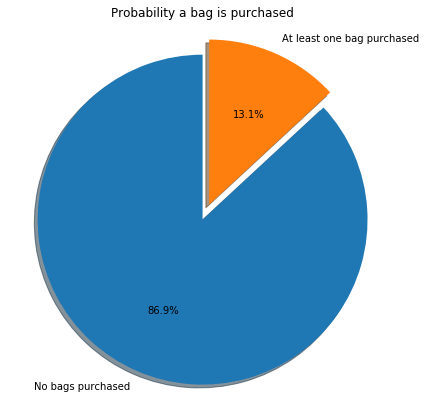

In [61]:
fig,ax=plt.subplots(figsize=(7,7))
s2=dict(df.Booked.value_counts())
vals=list(s2.values())
labels=['No bags purchased', 'At least one bag purchased']
explode=(0,0.1)
#fig1, ax1 = plt.subplots()
ax.pie(vals, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Probability a bag is purchased')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('piechart.png')
plt.show()


## Effect of flight departure month on the probablity a bag is purchased

In [62]:
bagsbyMonth= bagsdf.groupby(['TripFirstTravelMonth', 'QuantityBooked']).size().reset_index(name='counts')

In [63]:
#get the number of bags purchased each month
month={}
for i in range(1,13):
    sum=0
    
    for ind in bagsbyMonth.index:
        if (bagsbyMonth.TripFirstTravelMonth[ind]==i):
            sum = sum + bagsbyMonth.QuantityBooked[ind]*bagsbyMonth.counts[ind]
        month[i]=sum
    

In [64]:
#winter=['Jan','Nov', 'Dec']
#spring=['Feb', 'Mar', 'Apr']
#summer=['May', 'Jun', 'Jul']
#autumn=['Aug', 'Sep', 'Oct']

In [65]:
winter={'Jan':1,'Nov':11, 'Dec':12}
spring={'Feb':2, 'Mar':3, 'Apr':4}
summer={'May':5, 'Jun':6, 'Jul':7}
autumn={'Aug':8, 'Sep':9, 'Oct':10}

C:\Users\oyino\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


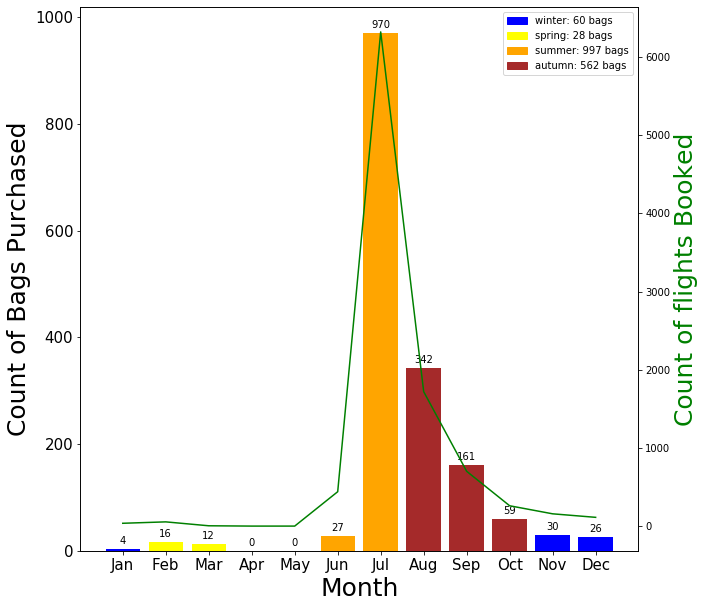

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
from matplotlib.patches import Patch


color=dict.fromkeys(list(winter.keys()), 'blue')
color.update(dict.fromkeys(list(spring.keys()) , 'yellow'))
color.update(dict.fromkeys(list(summer.keys()) , 'orange'))
color.update(dict.fromkeys(list(autumn.keys()) , 'brown'))
colours={'winter': 'blue', 'spring':'yellow', 'summer':'orange', 'autumn':'brown'}

time=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
color={k:color[k] for k in time}

im=ax.bar(month.keys(), month.values(), color=color.values())

#caculates the number of bags booked each season
def bagsSeason(season):
    sum=0
    for i in season.values():
        sum+=month[i]

    return str(sum)

handlesleg=[
    Patch(color='blue', label='winter: ' + bagsSeason(winter) + ' bags'),
    Patch(color='yellow', label='spring: ' + bagsSeason(spring)+ ' bags'),
    Patch(color='orange', label='summer: ' + bagsSeason(summer)+ ' bags'),
    Patch(color='brown', label='autumn: ' + bagsSeason(autumn)+ ' bags')
]
plt.legend(handles=handlesleg)
#time=range(1,13,1)
ax.set_xticks(range(1,13,1))
ax.set_xticklabels(time)
ax.tick_params(labelsize=15)
ax.set_xlabel("Month", fontsize=25)
ax.set_ylabel("Count of Bags Purchased", fontsize=25)
ax.set_title("Count of Bags and flights for each Month", fontsize=40)

#subscripts showing the number of bags purchased
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
        


autolabel(im)

monthFreq=dict(df['TripFirstTravelMonth'].value_counts())
#give a 0 value for months that don't appear in the dataset
monthFreq[4]=0
monthFreq[5]=0
#monthFreq[0]=0

monthFreq=dict(sorted(monthFreq.items()))

ax2=ax.twinx()
ax2.plot(list(month.keys()), list(monthFreq.values()), color='green')
ax2.set_ylabel('Count of flights Booked', color='green', fontsize=25)
plt.savefig('bags_flights.png')
fig.show()
#to do


## The probability a bag is booked in each month

In [67]:
probMonth=df.groupby(['TripFirstTravelMonth', 'Booked']).size().reset_index(name='counts')

In [68]:
#drop rows where booked = 0
probMonth=probMonth[probMonth.Booked !=0]

In [69]:
probMonth

,TripFirstTravelMonth,Booked,counts
1,1,1,4
3,2,1,8
5,3,1,2
7,6,1,22
9,7,1,800
11,8,1,265
13,9,1,99
15,10,1,43
17,11,1,25
19,12,1,17


In [70]:
monthFreq.pop(4)
monthFreq.pop(5)
freq=[]
for x, y in monthFreq.items():
    freq.append(y)

In [71]:
freq

[36, 54, 4, 440, 6323, 1720, 701, 260, 157, 112]

In [72]:
probMonth['MonthFreq']=pd.Series()
probMonth['MonthFreq']=freq

In [73]:
probMonth

,TripFirstTravelMonth,Booked,counts,MonthFreq
1,1,1,4,36
3,2,1,8,54
5,3,1,2,4
7,6,1,22,440
9,7,1,800,6323
11,8,1,265,1720
13,9,1,99,701
15,10,1,43,260
17,11,1,25,157
19,12,1,17,112


In [74]:
#calculate the purchasing probability for each month
probMonth['probability'] = probMonth['counts']/probMonth['MonthFreq']

In [75]:
probMonth.set_index('TripFirstTravelMonth', inplace=True)

In [76]:
probMonth_dict=dict(probMonth['probability'])
probMonth_dict[4]=0
probMonth_dict[5]=0
probMonth_dict=dict(sorted(probMonth_dict.items()))

In [77]:
probMonth_dict

{1: 0.1111111111111111,
 2: 0.14814814814814814,
 3: 0.5,
 4: 0,
 5: 0,
 6: 0.05,
 7: 0.12652222046496917,
 8: 0.15406976744186046,
 9: 0.14122681883024252,
 10: 0.16538461538461538,
 11: 0.1592356687898089,
 12: 0.15178571428571427}

C:\Users\oyino\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


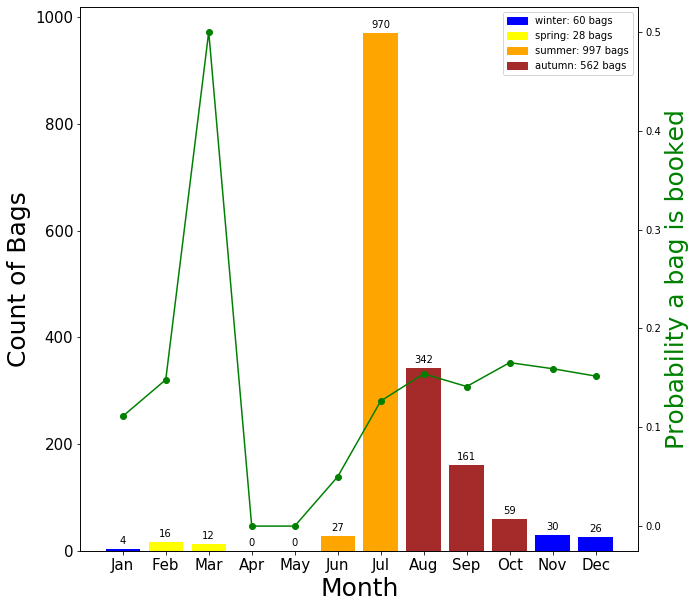

In [78]:
fig, ax = plt.subplots(figsize=(10,10))
#color=['red'] + ['green']*3 + ['blue']*3 + ['yellow']*3 +['red']*2
from matplotlib.patches import Patch


color=dict.fromkeys(list(winter.keys()), 'blue')
color.update(dict.fromkeys(list(spring.keys()) , 'yellow'))
color.update(dict.fromkeys(list(summer.keys()) , 'orange'))
color.update(dict.fromkeys(list(autumn.keys()) , 'brown'))
colours={'winter': 'blue', 'spring':'yellow', 'summer':'orange', 'autumn':'brown'}

time=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
color={k:color[k] for k in time}

im=ax.bar(month.keys(), month.values(), color=color.values())


def bagsSeason(season):
    sum=0
    for i in season.values():
        sum+=month[i]

    return str(sum)

handlesleg=[
    Patch(color='blue', label='winter: ' + bagsSeason(winter) + ' bags'),
    Patch(color='yellow', label='spring: ' + bagsSeason(spring)+ ' bags'),
    Patch(color='orange', label='summer: ' + bagsSeason(summer)+ ' bags'),
    Patch(color='brown', label='autumn: ' + bagsSeason(autumn)+ ' bags')
]
plt.legend(handles=handlesleg)
#time=range(1,13,1)
ax.set_xticks(range(1,13,1))
ax.set_xticklabels(time)
ax.tick_params(labelsize=15)
ax.set_xlabel("Month", fontsize=25)
ax.set_ylabel("Count of Bags", fontsize=25)
#ax.set_title("Count & Probability across the Months", fontsize=40)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
        


autolabel(im)

ax2=ax.twinx()
ax2.plot(list(month.keys()), list(probMonth_dict.values()), marker='o', color='green')
ax2.set_ylabel('Probability a bag is booked', fontsize=25, color='green')
plt.savefig('count_prob.png')
fig.show()


## The effect of WeekendStay on

In [80]:
df.weekendStay.value_counts()

1    8285
0    1522
Name: weekendStay, dtype: int64

In [81]:
probweekendStay={}
isweekendStay=df[df.weekendStay==1]
probweekendStay[1]=isweekendStay[isweekendStay.Booked==1].shape[0]/isweekendStay.shape[0]

notweekendStay=df[df.weekendStay==0]
probweekendStay[0]=notweekendStay[notweekendStay.Booked==1].shape[0]/notweekendStay.shape[0]

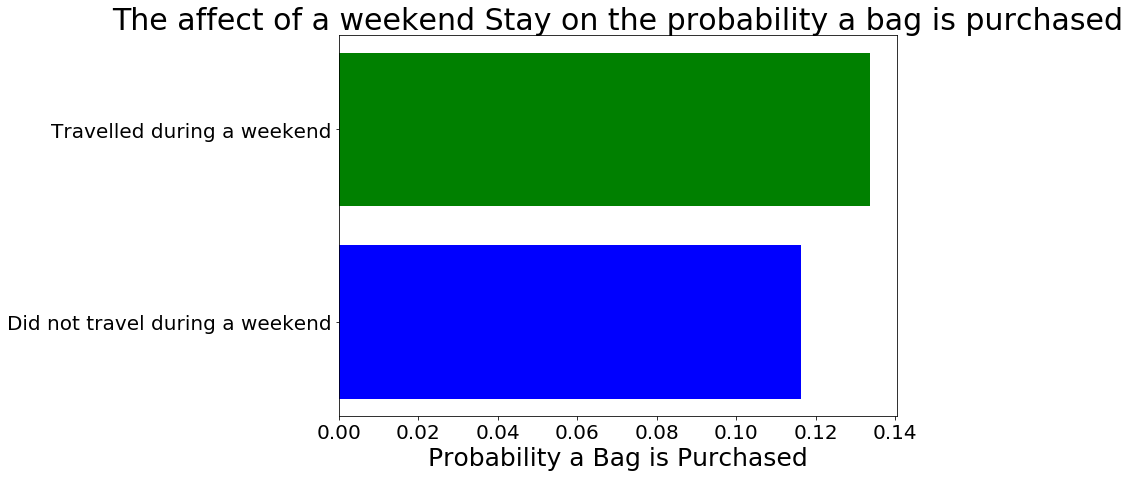

In [82]:
fig, ax = plt.subplots(figsize=(10,7))
ax.barh(['Travelled during a weekend', 'Did not travel during a weekend'], probweekendStay.values(), align='center', color=['green','blue'])
ax.invert_yaxis()
ax.tick_params(labelsize=20)
ax.set_title("The affect of a weekend Stay on the probability a bag is purchased", fontsize=30)
ax.set_xlabel("Probability a Bag is Purchased", fontsize=25)
#plt.savefig('weekendProb.png',bbox_inches='tight')
plt.show()

# Splitting Data

In [83]:
#remove column holding the number of bags purchased -> not needed
df.pop('QuantityBooked')

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       1
8       0
9       1
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      1
18      0
19      1
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      1
       ..
9970    0
9971    0
9972    0
9973    0
9974    0
9975    0
9976    0
9977    0
9978    0
9979    0
9980    0
9981    0
9982    0
9983    0
9984    1
9985    0
9986    0
9987    0
9988    0
9989    0
9990    0
9991    0
9992    0
9993    0
9994    0
9995    0
9996    2
9997    0
9998    2
9999    0
Name: QuantityBooked, Length: 9807, dtype: int64

In [84]:
df.to_csv('cleanedData.csv', index=False)

In [85]:
df.shape

(9807, 494)

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
train, test=train_test_split(df, test_size = 0.2, random_state = 42)

In [88]:
train.to_csv('trainSet.csv',index=False)

In [89]:
test.to_csv('testSet.csv',index=False)